In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [42]:
data = pd.read_csv('data/review_clean.csv')
data = data.sample(frac=1, random_state=42)
data

,combined_review,sentiment_label
35253,staff helpful location great,Good
364142,bed ok would like big bed except devided bed,Good
145135,tiny room paper thin wall meaning hear everyth...,Bad
306229,delicious complimentary cake arrival,Good
70175,room underground wifi work friendly staff,Good
...,...,...
259178,bad room service clean nice modern,Good
365838,small point mean loud fridge room kept awake d...,Good
131932,asked sewing kit 4 5 star hotel would odd hair...,Good
146867,extremely helpful staff especially concierge p...,Good


In [43]:
x = data['combined_review'].values
y = data['sentiment_label'].values

In [44]:
review_train, review_test, label_train, label_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [45]:
review_train

array(['everything monument perfect six star rating would select 6',
       'bed super', 'room hot excellent customer service friendly staff',
       ..., 'beautiful breakfast enough fill u came home',
       'people front desk manager rude helpful could figure send receive fax interest polite offer travel suggestion room nice location forgettable',
       'thing london still quite expensive nice room friendly staff great atmosphere'],
      dtype=object)

In [46]:
review_test

array(['nothing quiet easy get good night sleep',
       'room layout cupboard room airport shuttle elevator need refurbishment location quiet room',
       'receptionist friendly answer question one word yes', ...,
       'one girl named veladimir reception ignorant attitude guest acceptable instead guiding guest try show norm try undermine guest require hospitality course rest staff good friendly room comfort value money cleaniness',
       'hard pillowswhich impacted comfortable sleep good breakfast buffet large choice food available complimentary drink fridge appreciated summer',
       'nothing really would definitely stay room spacious bed comfortable also liked shop well within walking distance check check efficient front desk staff friendly helpful really liked free soft drink fridge sky sport tv also liked elemi bathroom product'],
      dtype=object)

In [47]:
label_train

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [48]:
label_test

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [49]:
label_train = pd.get_dummies(label_train, columns=['sentiment_label'])
label_test = pd.get_dummies(label_test, columns=['sentiment_label'])


In [50]:
label_train = np.array(label_train)
label_train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [51]:
label_test = np.array(label_test)
label_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [52]:
review_train

array(['everything monument perfect six star rating would select 6',
       'bed super', 'room hot excellent customer service friendly staff',
       ..., 'beautiful breakfast enough fill u came home',
       'people front desk manager rude helpful could figure send receive fax interest polite offer travel suggestion room nice location forgettable',
       'thing london still quite expensive nice room friendly staff great atmosphere'],
      dtype=object)

In [53]:
review_test

array(['nothing quiet easy get good night sleep',
       'room layout cupboard room airport shuttle elevator need refurbishment location quiet room',
       'receptionist friendly answer question one word yes', ...,
       'one girl named veladimir reception ignorant attitude guest acceptable instead guiding guest try show norm try undermine guest require hospitality course rest staff good friendly room comfort value money cleaniness',
       'hard pillowswhich impacted comfortable sleep good breakfast buffet large choice food available complimentary drink fridge appreciated summer',
       'nothing really would definitely stay room spacious bed comfortable also liked shop well within walking distance check check efficient front desk staff friendly helpful really liked free soft drink fridge sky sport tv also liked elemi bathroom product'],
      dtype=object)

In [54]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(review_train)

train_sequences = tokenizer.texts_to_sequences(review_train)
test_sequences = tokenizer.texts_to_sequences(review_test)

In [55]:
maxlen = 50
train_padded = pad_sequences(train_sequences, 
                            padding='post',
                            maxlen=maxlen,
                            truncating='post')

test_padded = pad_sequences(test_sequences,
                            padding='post',
                            maxlen=maxlen,
                            truncating='post')

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16, input_length=maxlen,
                            embeddings_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=32, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [57]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

c:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            80000     
                                                                 
 gru_4 (GRU)                 (None, 50, 64)            15744     
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 105,218
Trainable params: 105,218
Non-tr

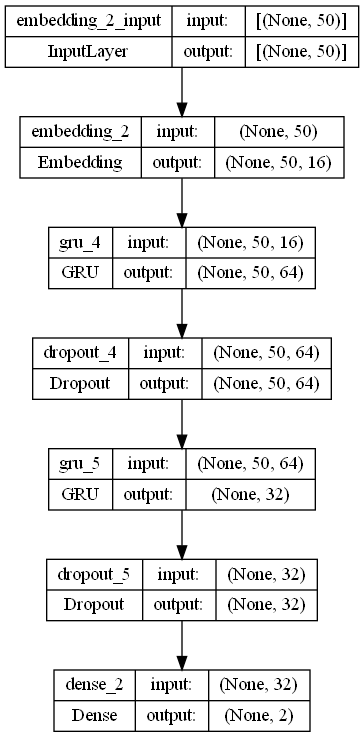

In [63]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [59]:

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95:
            print("\nAkurasi telah mencapai >= 95%")
            self.model.stop_training = True
            
callbacks = myCallback()


In [60]:
history = model.fit(train_padded, label_train, 
        epochs=20, 
        batch_size=128, 
        validation_data=(test_padded, label_test), 
        callbacks=[callbacks])

Epoch 1/20
3043/3043 [==============================] - 515s 164ms/step - loss: 0.1901 - accuracy: 0.9414 - val_loss: 0.1649 - val_accuracy: 0.9416
Epoch 2/20
3043/3043 [==============================] - 530s 174ms/step - loss: 0.1629 - accuracy: 0.9449 - val_loss: 0.1583 - val_accuracy: 0.9463
Epoch 3/20
3043/3043 [==============================] - 441s 145ms/step - loss: 0.1585 - accuracy: 0.9460 - val_loss: 0.1530 - val_accuracy: 0.9482
Epoch 4/20
3043/3043 [==============================] - 438s 144ms/step - loss: 0.1569 - accuracy: 0.9464 - val_loss: 0.1529 - val_accuracy: 0.9476
Epoch 5/20
3043/3043 [==============================] - 440s 145ms/step - loss: 0.1558 - accuracy: 0.9470 - val_loss: 0.1561 - val_accuracy: 0.9475
Epoch 6/20
3043/3043 [==============================] - 441s 145ms/step - loss: 0.1553 - accuracy: 0.9470 - val_loss: 0.1523 - val_accuracy: 0.9481
Epoch 7/20
3043/3043 [==============================] - 485s 159ms/step - loss: 0.1543 - accuracy: 0.9473 - val_

3043/3043 [==============================] - 46s 14ms/step


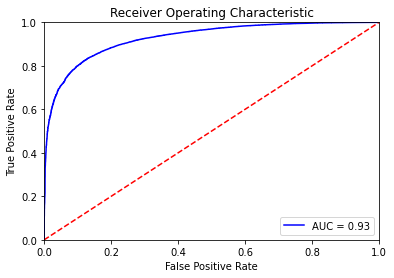

In [65]:
y_pred_prob = model.predict(test_padded)

fpr, tpr, threshold = roc_curve(label_test[:, 1], y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [66]:
model.evaluate(test_padded, label_test)

3043/3043 [==============================] - 44s 15ms/step - loss: 0.1484 - accuracy: 0.9494


[0.1484133005142212, 0.9494006633758545]

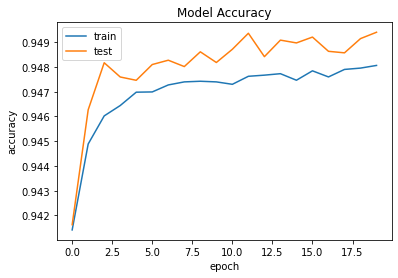

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

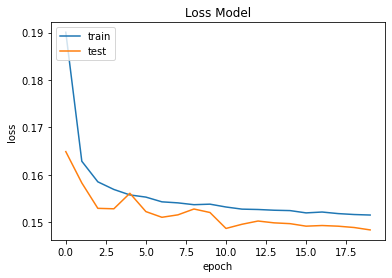

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()